In order to run this notebook locally you will need
- a local instsallation of feltor: follow the quick-start guide https://github.com/feltor-dev/feltor (we do need jsoncpp and netcdf, but not glfw, and a link to path/to/feltor/inc/dg in home/include)
- a local installation of simplesimdb: follow the quick-start guide https://github.com/mwiesenberger/simplesimdb
- to compile the cpp codes in this repository: type make in a shell

## One-dimensional hyperbolic systems

### Advection equation

First we are going to study the one-dimensional advection equation 
\begin{align}
     \frac{\partial }{\partial t} n= - a \frac{\partial}{\partial x} n + \nu \frac{\partial^2}{\partial x^2} n
 \end{align}
We are going to compare the first order upwind scheme with a centered differences scheme.
 We discretize space with a cell-centered grid of $N_x$ points on the domain $[x_0,x_1]$. 
 Further, we implemented a discontinuous Galerkin scheme with flux-limiter.
 
 In time we use the Bogacki-Shampine adaptive method of order 3 (adaption of order 2).
 
 We use Neumann boundary conditions and as initial condition we use the classical problem of a step function
 \begin{align}
    n(x,0) = \begin{cases} 1 \text{ for } x < x_a \\ 0 \text{ else}\end{cases}
 \end{align}
 
 As an alternative initial condition we can choose a wave function
 \begin{align}
     n(x,0) = n_0 + A \sin( k(x-x_0))
 \end{align}
    
We also remark that the advection equation has a simple analytical 
solution
\begin{align}
    n(x,t) = n(x-at, 0)
\end{align}

In [1]:
import numpy as np
import simplesimdb as simplesim
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [2]:
# The code continuity.cpp discretizes the continuity equation
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_continuity_input() :
    return {
    "grid" : {
        "n" : 3, # only relevant for dg schemes
        "Nx" : 32, # number of grid points
        "x" : [0, 1], # spatial domain [x_0,x_1]
        "bc" : "NEU" # one of PER, NEU, DIR, DIR_NEU, NEU_DIR
    },
    "init": # initial condition
    {
        "type":"step", 
        "x_a" : 0.25 # location of step
#         "type" : "wave",
#         "n_0" 1.0,
#         "amp" : 1.0
#         "k"   : 1.0
#         "x_0" : 1.0
    },
    "advection" : { # numerical discretization
        "type" : "upwind",
        # upwind (classical 1st order upwind)
        # upwind2 (2nd order upwind formula)
        # centered (2nd order centered differences)
        # dg-upwind (n-th order discontinuous Galerkin)
        "alpha" : 10 # (Limiter parameter for dg-upwind scheme)
    },
    "timestepper":
    {
        # We implemented an adaptive embedded Runge Kutta method
        # (see the following link for a list)
        #https://feltor-dev.github.io/doc/dg/html/structdg_1_1_e_r_k_step.html
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-5,
        "atol" : 1e-6
        
    },
    "physical":
    {
        "velocity" : 1.0, # a in Eq. 1
        "nu" : 0.0 
        # if non-zero a diffusion term is added to Eq. 1
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 0.25, # end time
        # Choose a number of (equidistant in time) outputs
        # in output file (excluding first)
        "maxout" : 20 
    }
    }


In [3]:
# Let us run our first simulation and get an overview over
# the output file.

# We run simulations using the simplesimdb library
# In order for this to work you must first compile
# the code as described above, type:
# make continuity

# The simplesimdb library provides a simple python interface to the
# code via the Repeater class
# https://github.com/mwiesenberger/simplesimdb
rep = simplesim.Repeater("./continuity","temp.json", "temp.nc")
# in the following the temp.json and temp.nc files will be
# re-used for every simulation
rep.clean() # delete previously existing files
rep.run( make_continuity_input(), error="display", stdout="ignore")
# this will (i) write the input parameters to "temp.json"
# (ii) run the code, which
# (iii) produces the file "temp.nc"
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
# Now with the help of pythons netcdf library we can pretty print
# an overview of output file
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
time (21,)
x (32,) 	x-coordinate in Computational coordinate system
failed (21,) 	Accumulated Number of failed steps
duration (21,) 	Computation time for the latest output
nsteps (21,) 	Accumulated Number of calls to the RHS functor (including failed steps)
numerical (21, 32) 	Numerical solution: Advected variable
analytical (21, 32) 	Analytical solution


In [4]:
# Here we define a simple plot routine
# It loops over all parameter sets that we give it, runs the
# corresponding simulation and then plots the analytical and
# numerical solutions at the last timestep
def plot_upwind( p_list):
    frows = 1
    fcols = 1
    plt.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    plotted = False
    for p in p_list :
        rep.clean()
        rep.run( p, error="display")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        x = ncin.variables["x"][:]
        analytic = ncin.variables["analytical"][:,:]
        last_idx = ncin.variables["time"].shape[0]-1
        numerical = ncin.variables["numerical"][:,:]
        if not plotted :
            im = ax.plot(x,analytic[last_idx,:], color='k',
                     label="analytical", lw=2)
            plotted = True
        l = f"{p['advection']['type']}"
        im = ax.plot(x,numerical[last_idx,:], label=l, lw=2)
        print( "Number of rhs calls " , ncin["nsteps"][-1])
        ncin.close()
    ax.set_title( f"Advection equation in 1D with Nx = {p['grid']['Nx']} points")
    ax.set_xlabel( r"s [$\rho_s$]")
    ax.set_ylabel("n")
    ax.legend()


As a first example we solve the continuity equation with the
step function initial condition with various schemes

centered
centered
Number of rhs calls  479.0
Number of rhs calls  362.0


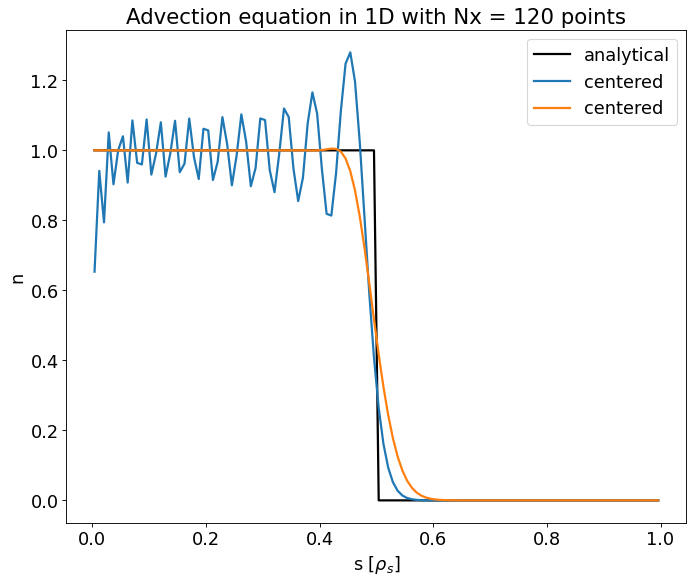

In [5]:
p_list = []
for p in ["centered"] :
    for nu in [0, 2e-3]:
        params = make_continuity_input()
        params["grid"]["Nx"] = 120
        print(p)
        params["advection"]["type"] = p
        params["physical"]["nu"] = nu

        p_list.append(params)
plot_upwind(p_list)

As expected the forward-in-time centered-in-space discretization shows stong oscillations in the upwind region. The second order upwind scheme has a strong overshoot and shows negative density in the downstream area.

Number of rhs calls  636.0
Number of rhs calls  17020.0


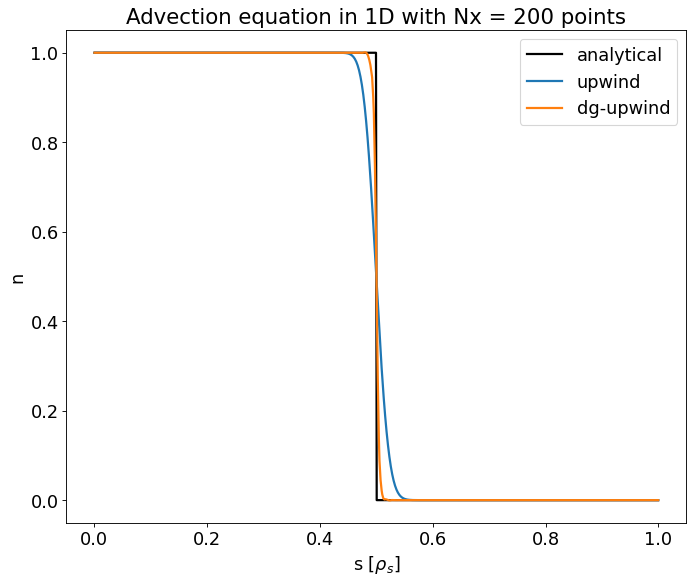

In [6]:
p_list = []

for p in ["upwind", "dg-upwind"] :
    #for nu in [0, 1e-2]:
        params = make_continuity_input()
        params["grid"]["Nx"] =800
    
        params["advection"]["type"] = p
        #params["physical"]["nu"] = nukj
        if p == "dg-upwind" : 
            params["grid"]["n"] =3
            params["grid"]["Nx"] = 200
            params["advection"]["alpha"] = 400 # no filter
        p_list.append(params)
plot_upwind(p_list)

{'grid': {'n': 3, 'Nx': 1000, 'x': [0, 1], 'bc': 'NEU'}, 'init': {'type': 'step', 'x_a': 0.25}, 'advection': {'type': 'upwind', 'alpha': 10}, 'timestepper': {'tableau': 'Bogacki-Shampine-4-2-3', 'rtol': 1e-05, 'atol': 1e-06}, 'physical': {'velocity': 1.0, 'nu': 0.0}, 'output': {'tend': 0.1, 'maxout': 20}}
Number of rhs calls  464.0


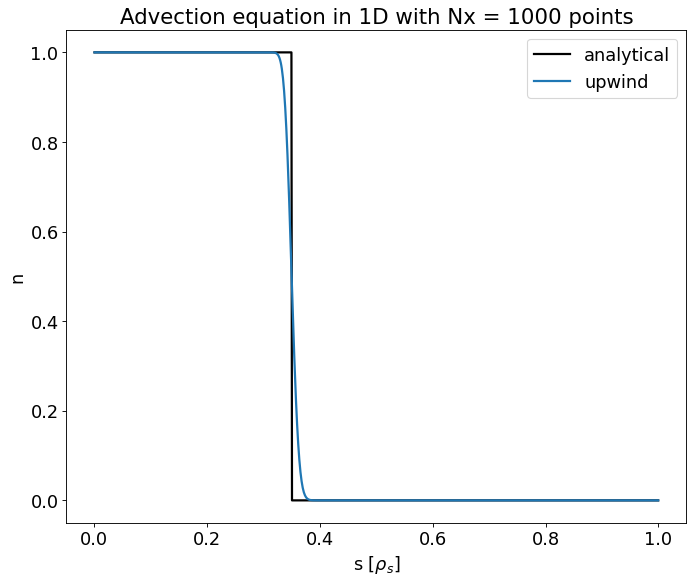

In [7]:

params = make_continuity_input()
params["grid"]["Nx"] = 1000
params["grid"]["x"] = [0,1]
params["physical"]["nu"] = 0.0

params["physical"]["velocity"] = 1.0
params["output"]["tend"] = 0.1
# params["init"] = {"type" : "wave", "amp" : 0.5,
#                   "n_0" : 1, "k" : 10*np.pi, "x_0" : 0}
params["init"]["x_a"] = 0.25
print(params)
p_list=[params]
plot_upwind(p_list)

{'grid': {'n': 3, 'Nx': 60, 'x': [0, 1], 'bc': 'NEU'}, 'init': {'type': 'step', 'x_a': 0.25}, 'advection': {'type': 'upwind', 'alpha': 10}, 'timestepper': {'tableau': 'Bogacki-Shampine-4-2-3', 'rtol': 1e-05, 'atol': 1e-06}, 'physical': {'velocity': 1.0, 'nu': 0.0}, 'output': {'tend': 0.25, 'maxout': 20}}


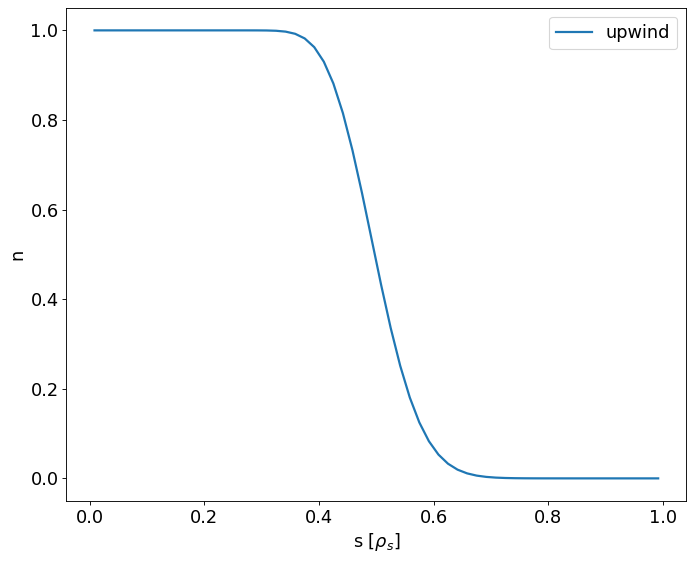

In [8]:
params = make_continuity_input()
params["grid"]["Nx"] = 60
print(params)
frows = 1
fcols = 1
fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
#https://matplotlib.org/stable/tutorials/colors/colormaps.html

# plotted = False
rep.clean()
rep.run( params, error="display")
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
x = ncin.variables["x"][:]
analytic = ncin.variables["analytical"][:,:]
last_idx = ncin.variables["time"].shape[0]-1
numerical = ncin.variables["numerical"][:,:]
# if not plotted :
#     im = ax.plot(x,analytic[last_idx,:], color='k',
#              label="analytical", lw=2)
#     plotted = True
l = f"{params['advection']['type']}"
im = ax.plot(x,numerical[last_idx,:], label=l, lw=2)
ncin.close()
# ax.set_title( f"Advection equation in 1D with Nx = {params['grid']['Nx']} points")
ax.set_xlabel( r"s [$\rho_s$]")
ax.set_ylabel("n")
ax.legend()

The first order upwind scheme shows a smooth transition (strong numerical diffusion) of the step while the discontinuous Galerkin scheme (of order 3) shows overshoot in both upwind and downwind regions.

Number of rhs calls  2470.0
Number of rhs calls  1305.0
Number of rhs calls  260.0


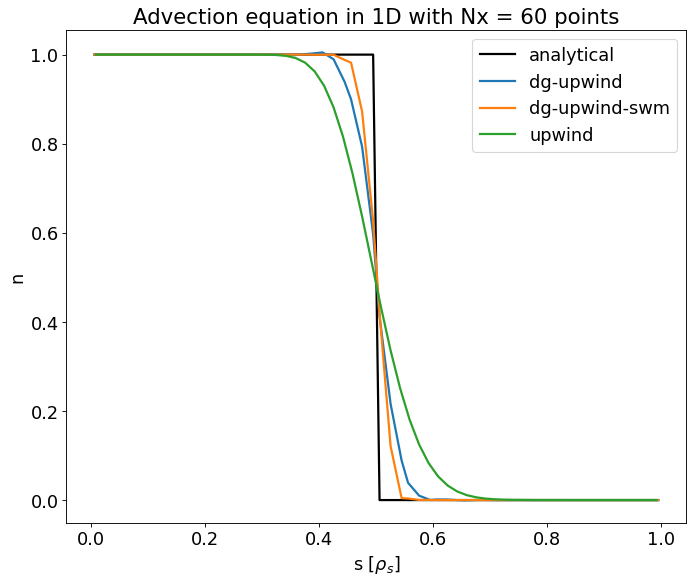

In [9]:
p_list = []

for p in ["dg-upwind","dg-upwind-swm","upwind"] :
    #for nu in [0, 1e-2]:
        params = make_continuity_input()
        params["grid"]["Nx"] = 60
        params["advection"]["type"] = p
        #params["physical"]["nu"] = nu
        if p == "dg-upwind" : 
            params["grid"]["n"] =3
            params["grid"]["Nx"] = 20
            params["advection"]["alpha"] = 40 
        if p == "dg-upwind-swm" : # switching median filter
            params["grid"]["n"] =3
            params["grid"]["Nx"] = 20
            params["advection"]["alpha"] = 40
            params["advection"]["iter"] = 1
        p_list.append(params)
plot_upwind(p_list)

Here we show the discontinuos Galerkin scheme with two different filters. First the originally proposed flux limiter with $\alpha = 40$ in blue and switching Median filter in orange. For comparison we also plot the first order upwind scheme. As can be seen the dG schemes exhibit less numerical diffusion than the upwind scheme.

In summary we find the results:
- the upwind scheme of first order does not produce oscillations and has inherent numerical diffusion
- the upwind scheme of 2nd order produces oscillations downstream
- the centered scheme without diffusion is unconditionally unstable and produces lots of oscillations
- only the first order upwind and the discontinuous Galerkin with flux limiter produce smooth solutions

Number of rhs calls  494.0
Number of rhs calls  423.0
Number of rhs calls  9277.0
Number of rhs calls  1708.0


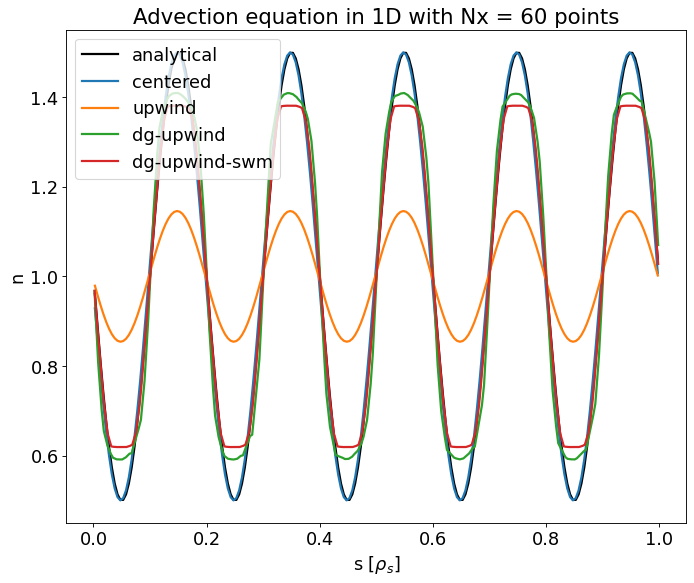

In [10]:
p_list = []
for p in ["centered","upwind","dg-upwind", "dg-upwind-swm",] :
#    for nu in [0, 1e-3]:
        params = make_continuity_input()
        params["grid"]["Nx"] = 200
        params["grid"]["bc"] = "PER"
        params["output"]["tend"] = 0.5
        params["init"] = {"type" : "wave", "amp" : 0.5,
                          "n_0" : 1, "k" : 10*np.pi, "x_0" : 0}
        params["advection"]["type"] = p
        #params["physical"]["nu"] = nu
        if p == "dg-upwind" : 
            params["grid"]["n"] =3
            params["grid"]["Nx"] = 61
            params["advection"]["alpha"] = 40
        if p == "dg-upwind-swm" : # switching median filter
            params["grid"]["n"] =3
            params["grid"]["Nx"] = 60
            params["advection"]["alpha"] = 40
            params["advection"]["iter"] = 1    
        p_list.append(params)
plot_upwind(p_list)

In the wave example we can see that
- the upwind scheme of 1st order has a lot of numerical diffusion 
- both the slope limiter dg-scheme as well as the switching median filter dampen local extrema, which can be lessened with the alpha parameter (at the cost of more oscillations after shocks)
- the 2nd order centered scheme seems to be stable without diffusion (which is a wrong conclusion as we know that centered differences are unstable, we conclude that the sine wave is not a good test function to test stability)


Number of rhs calls  643.0
Number of rhs calls  4607.0


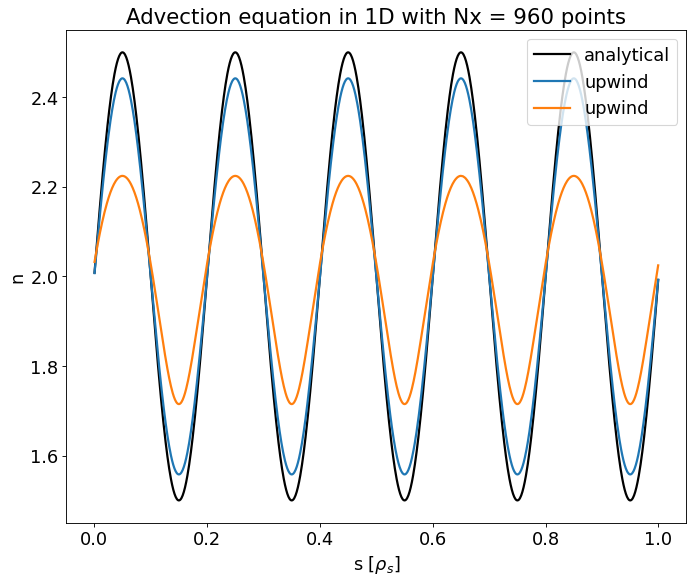

In [11]:
p_list = []


for nu in [0.5e-3]:
    for exp in [1,7/2]:
        params = make_continuity_input()
        params["grid"]["Nx"] =960
        params["init"]["x_a"] = .5
        params["grid"]["bc"] = "PER"
        params["advection"]["type"] = "upwind"
        params["init"] = {"type" : "wave", "amp" : 0.5,
                          "n_0" : 2, "k" : 10*np.pi, "x_0" : 0}
        params["physical"]["velocity"] = 0
        params["physical"]["nu"] = nu/exp
        params["physical"]["exponent"] = exp
        p_list.append(params)
plot_upwind(p_list)

diesel
Number of rhs calls  12425.0


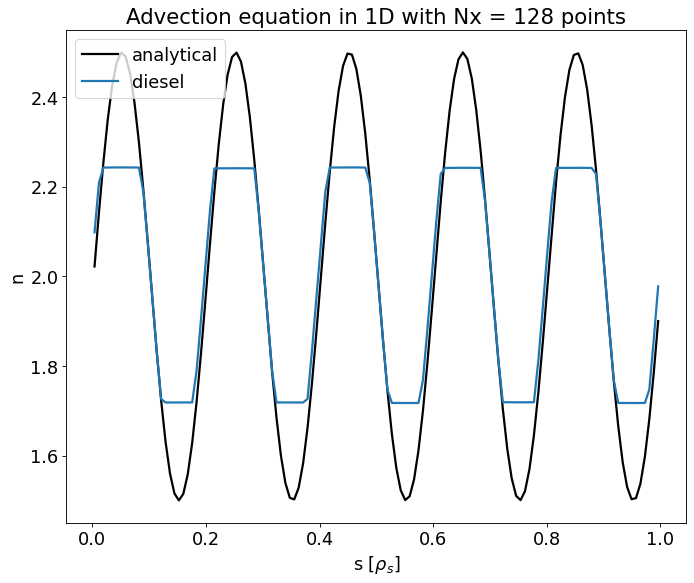

In [12]:
p_list = []
for p in ["diesel"] :
    params = make_continuity_input()
    params["grid"]["Nx"] = 128
    params["grid"]["bc"] = "PER"
    params["grid"]["x"]  = [0,1]
    # params["init"] = {
    #     "type"  : "gaussian",
    #     "amp" : 2,
    #     "sigma" : 0.1,
    #     "x_0" : 0.5
    # }
    params["init"] = {"type" : "wave", "amp" : 0.5,
                          "n_0" : 2, "k" : 10*np.pi, "x_0" : 0}
    print(p)
    params["output"]["tend"] = 0.005
    params["advection"]["type"] = p
    params["physical"]["nu"] = 0.00
    params["physical"]["velocity"] = 0.5

    p_list.append(params)
plot_upwind(p_list)